In [63]:
# Standard imports
import os
import cv2
import math
import numpy as np
import pandas as pd
import numpy.linalg as la
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNetCV, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Statsmodels imports
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ensure inline plotting for Jupyter notebooks
%matplotlib inline

Data Pre-Processing

In [64]:
df = pd.read_csv('nba2.csv')

# Impute NAs in the data
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_imputer = SimpleImputer(strategy='mean')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

df = df.iloc[:, 6:] 

df.head()

,W/L%,MP,FG,FGA,2P,2PA,3P,3PA,FT,FTA,...,O_FTA,O_ORB,O_DRB,O_TRB,O_AST,O_STL,O_BLK,O_TOV,O_PF,O_PTS
0,0.439,242.1,43.0,92.5,29.3,54.8,13.7,37.7,18.5,23.2,...,21.8,10.6,33.6,44.2,28.2,7.8,5.6,14.1,19.4,120.5
1,0.780,241.8,43.9,90.2,27.4,47.7,16.5,42.5,16.3,20.2,...,17.3,11.1,32.3,43.3,24.9,6.2,3.7,12.0,17.3,109.2
2,0.256,240.6,40.0,87.0,28.0,53.0,12.1,34.0,14.5,18.4,...,20.7,10.6,34.8,45.4,28.7,7.1,4.8,13.6,17.5,116.8
3,0.476,243.7,42.0,89.5,30.6,57.4,11.5,32.1,16.7,21.1,...,21.8,10.1,33.3,43.4,27.9,6.8,4.9,14.0,18.8,113.7
4,0.585,241.5,41.8,87.2,28.3,50.4,13.5,36.8,15.6,20.4,...,21.0,10.0,32.6,42.7,25.3,7.7,5.0,13.6,18.7,110.2


In [65]:
# the per game stats
X = df.iloc[:, 1:]
X.shape

(1023, 35)

In [66]:
# win percent in a season
y = df.iloc[:, 0]
y.shape

(1023,)

In [67]:
X_train, X_new, y_train, y_new = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_new.shape)
print(y_train.shape, y_new.shape)

(716, 35) (307, 35)
(716,) (307,)


In [68]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [69]:
# Center the data for PCA
mu = np.mean(X_train,axis = 0, keepdims = True)
X_train_tilde = X_train - mu
X_train_tilde.shape

(716, 35)

In [70]:
U,S,VT = np.linalg.svd(X_train_tilde, full_matrices=False)

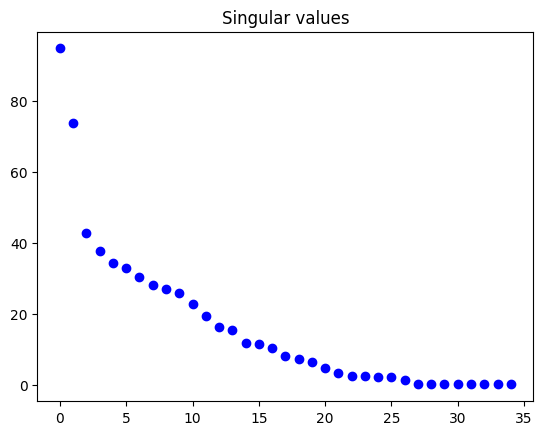

In [71]:
plt.plot(S,'bo')
plt.title('Singular values')
plt.show()

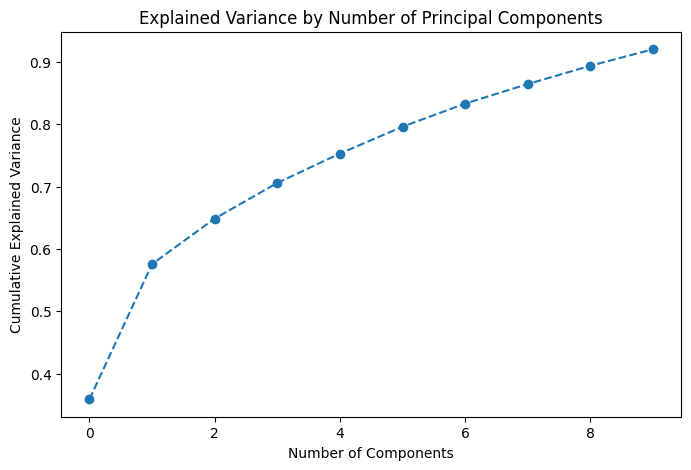

In [72]:
# PCA
pca = PCA(n_components=10)  # Using the 10 highest singular values
X_train_tilde_pca = pca.fit_transform(X_train_tilde)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.show()

In [73]:
# Transform the new data using the same steps
X_new = scaler.transform(X_new)  # Standardize
X_new_tilde = X_new - mu  # Center
X_new_tilde_pca = pca.transform(X_new_tilde)  # Apply PCA

Model Performance Comparison:
                            Model       MSE  R-squared  Adjusted R-squared
0               Linear Regression  0.004094   0.826378            0.820513
1                Ridge Regression  0.004094   0.826391            0.820526
2                Lasso Regression  0.023588  -0.000327           -0.034122
3                     Elastic Net  0.023588  -0.000327           -0.034122
4        Decision Tree Regression  0.013224   0.439199            0.420253
5        Random Forest Regression  0.005535   0.765285            0.757355
6    Gradient Boosting Regression  0.005188   0.779984            0.772551
7       Support Vector Regression  0.005232   0.778126            0.770631
8  K-Nearest Neighbors Regression  0.007061   0.700538            0.690421


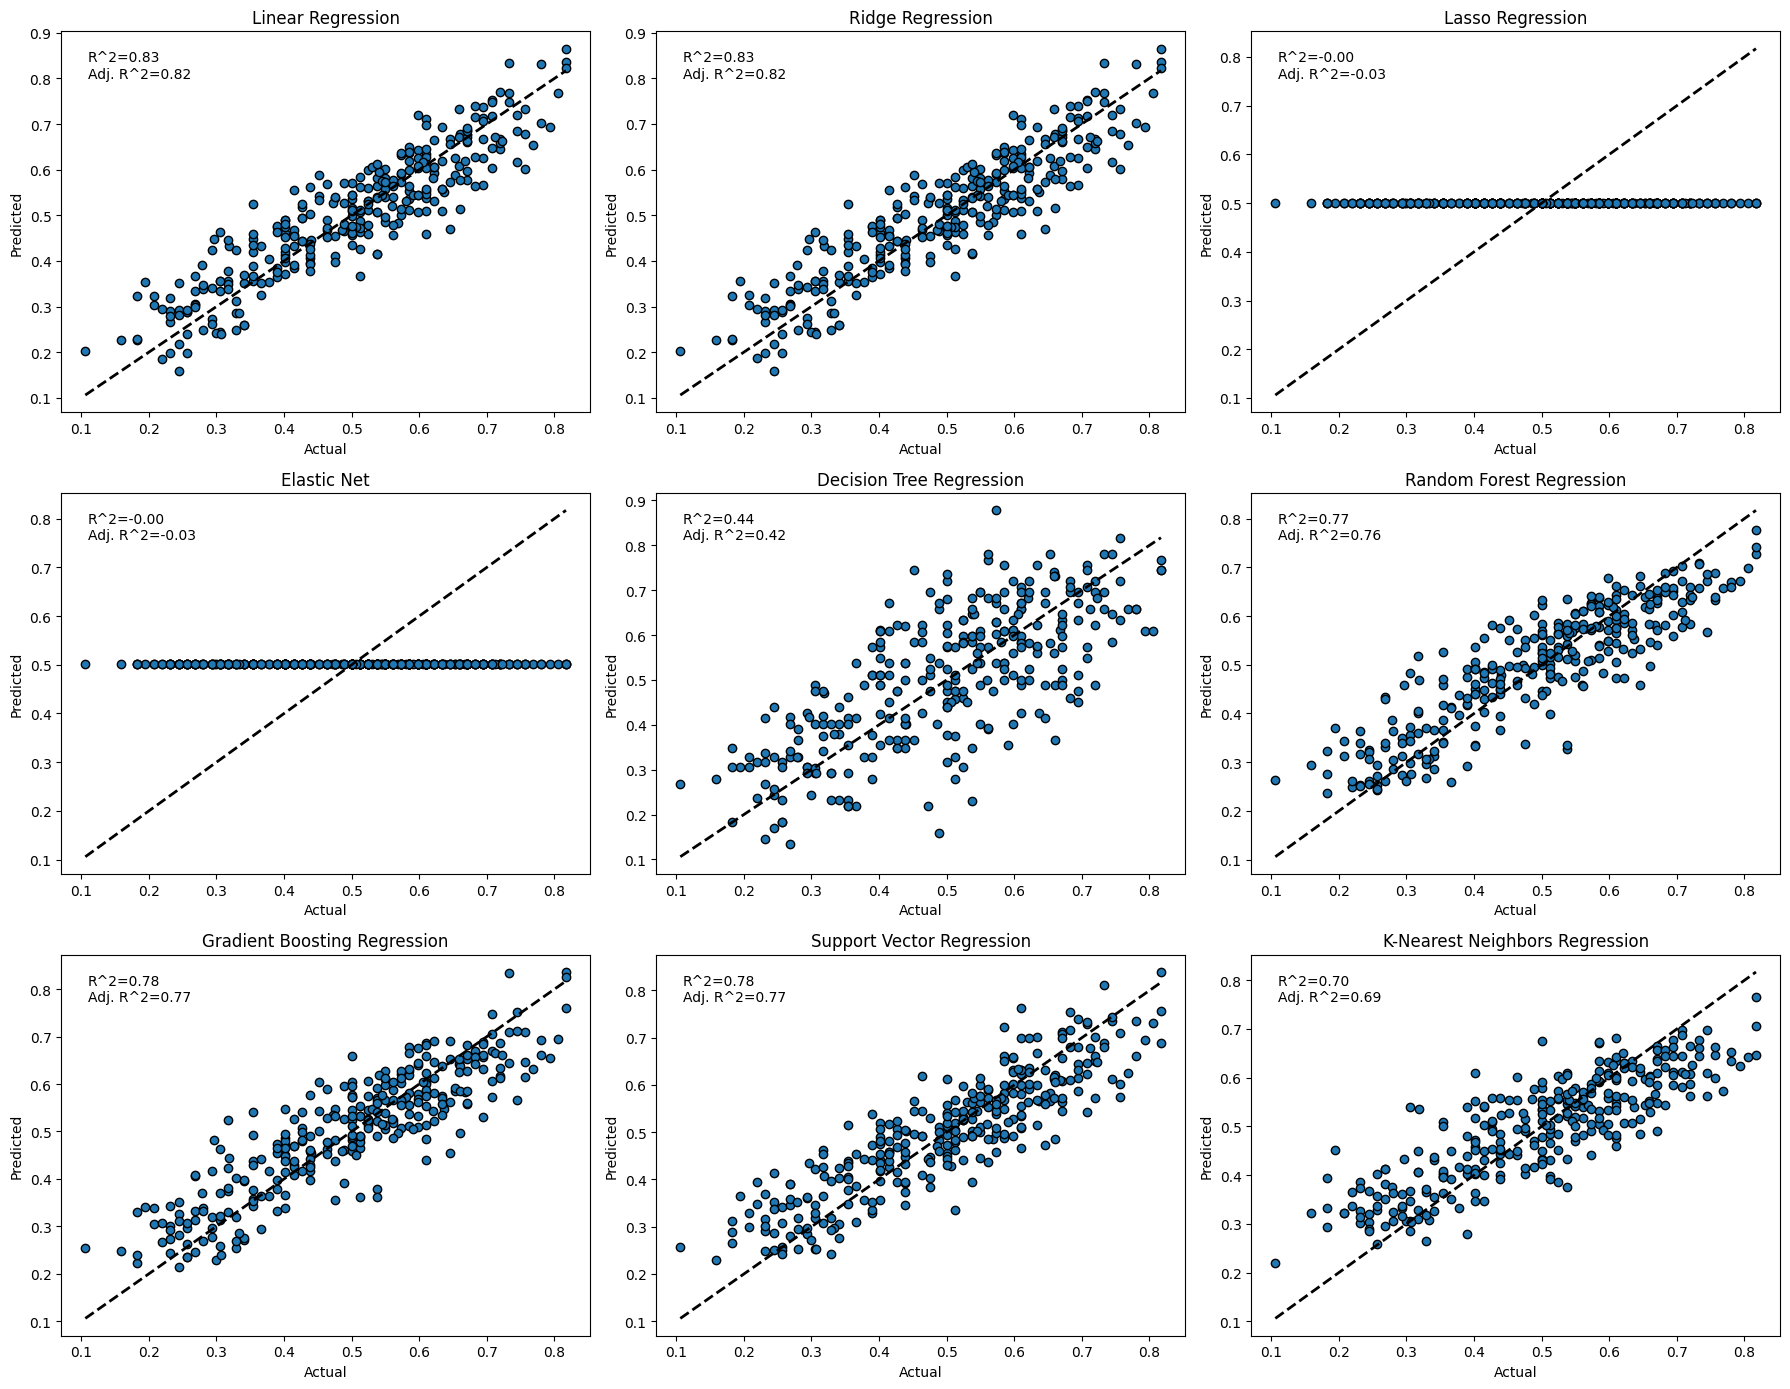

In [74]:
# Models initialization
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(random_state=42),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR(),
    'K-Nearest Neighbors Regression': KNeighborsRegressor()
}

# Dictionaries to store results
mse_results = {}
r2_results = {}
adj_r2_results = {}

# Training and prediction
n = X_new_tilde_pca.shape[0]
p = X_new_tilde_pca.shape[1]
for name, model in models.items():
    model.fit(X_train_tilde_pca, y_train)
    y_pred = model.predict(X_new_tilde_pca)
    mse_results[name] = mean_squared_error(y_new, y_pred)
    r2_results[name] = r2_score(y_new, y_pred)
    adj_r2_results[name] = 1 - (1 - r2_results[name]) * (n - 1) / (n - p - 1)

# Display results
results = pd.DataFrame({
    'Model': list(mse_results.keys()),
    'MSE': list(mse_results.values()),
    'R-squared': list(r2_results.values()),
    'Adjusted R-squared': list(adj_r2_results.values())
})

print("Model Performance Comparison:")
print(results)

# Plotting actual vs predicted values for each model
plt.figure(figsize=(18, 14))

# Iterate over models for plotting
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(3, 3, i)
    model.fit(X_train_tilde_pca, y_train)
    y_pred = model.predict(X_new_tilde_pca)
    plt.scatter(y_new, y_pred, edgecolors=(0, 0, 0))
    plt.plot([y_new.min(), y_new.max()], [y_new.min(), y_new.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(name)
    plt.text(0.05, 0.95, f'R^2={r2_results[name]:.2f}\nAdj. R^2={adj_r2_results[name]:.2f}',
             transform=plt.gca().transAxes,
             verticalalignment='top')

plt.tight_layout()
plt.show()

\begin{equation}
\text{Adjusted } R^2 = 1 - \left(1 - R^2\right) \frac{n - 1}{n - p - 1}
\end{equation}

n is the number of observations and p is the number of predictors

Hyperparameter Optimization:

Elastic Net

In [75]:
# elastic_cv = ElasticNetCV(l1_ratio = [(1 - math.exp(-i - 1e-10)) for i in range(50)], eps=1e-12, n_alphas=400, random_state=42, verbose=True, n_jobs=-1)
# elastic_cv.fit(X_train_tilde_pca, y_train)
# print(elastic_cv.l1_ratio_)
# print(elastic_cv.alpha_)
# print(elastic_cv.intercept_)
# y_elastic = elastic_cv.predict(X_new_tilde_pca)    
# mse_elastic = mean_squared_error(y_new, y_elastic)
# r2_elastic = r2_score(y_new, y_elastic)
# print(mse_elastic)
# print(r2_elastic)

Random Forrest Regressor

In [76]:
# rfr_params = {
#     "criterion": ["squared_error", "friedman_mse"],
#     "min_samples_split": [2, 3, 4],
#     "min_samples_leaf": [1, 2, 3],
#     "min_weight_fraction_leaf": [0, 0.005, 0.01, 0.02],
#     "max_features": [1.0, 3, 5, "log2"]
# }

# rfr = GridSearchCV(RandomForestRegressor(n_estimators=250, random_state=42), rfr_params, cv=5, n_jobs=-1, verbose=True)
# rfr.fit(X_train_tilde_pca, y_train)
# print(f"RFR Best Parameters: {rfr.best_params_}")
# y_rfr = rfr.predict(X_new_tilde_pca)
# mse_rfr = mean_squared_error(y_rfr, y_new)
# r2_rfr = r2_score(y_rfr, y_new)
# print(mse_rfr)
# print(r2_rfr)

Decision Tree Regressor

In [77]:
# dec_params = rfr_params

# dec = GridSearchCV(DecisionTreeRegressor(random_state=42), dec_params, cv=20, n_jobs=-1, verbose=True)
# dec.fit(X_train_tilde_pca, y_train)
# print(f"Decision Tree Best Parameters: {dec.best_params_}")
# y_dec = dec.predict(X_new_tilde_pca)
# mse_dec = mean_squared_error(y_dec, y_new)
# r2_dec = r2_score(y_dec, y_new)
# print(mse_dec)
# print(r2_dec)

Gradient Boost

In [78]:
# gb_params = {
#     "loss": ["squared_error"],
#     "learning_rate": [0.01, 0.1, 1],
#     "subsample": [(i+1)/5 for i in list(range(5))],
#     "criterion": ["squared_error", "friedman_mse"],
#     "min_samples_split": [2, 3, 4, 5],
#     "min_samples_leaf": [1, 2, 3],
#     "min_weight_fraction_leaf": [0, 0.005, 0.01],
#     "max_features": [1.0, 3, 5, "log2"]
# }

# gb = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=5, n_jobs=-1, verbose=True)
# gb.fit(X_train_tilde_pca, y_train)
# print(f"Gradient Boost Best Parameters: {gb.best_params_}")
# y_gb = gb.predict(X_new_tilde_pca)
# mse_gb = mean_squared_error(y_gb, y_new)
# r2_gb = r2_score(y_gb, y_new)
# print(mse_gb)
# print(r2_gb)

SVR

In [79]:
# svr_params = {
#     "kernel": ["poly", "rbf", "sigmoid"],
#     "degree": [3, 4, 5],
#     "gamma": ["scale", "auto"],
#     "tol": [1e-6],
#     "C": [0.1, 1, 10],
#     "epsilon": [0.01, 0.1, 0.5]
# }

# svr = GridSearchCV(SVR(), svr_params, cv=5, n_jobs=-1, verbose=True)
# svr.fit(X_train_tilde_pca, y_train)
# print(f"SVR Best Parameters: {svr.best_params_}")
# y_svr = svr.predict(X_new_tilde_pca)
# mse_svr = mean_squared_error(y_svr, y_new)
# r2_svr = r2_score(y_svr, y_new)
# print(mse_svr)
# print(r2_svr)

KNN

In [80]:
# knr_params = {
#     "n_neighbors": [x + 1 for x in range(15)],
#     "weights": ["uniform", "distance"],
#     "algorithm": ["ball_tree", "kd_tree", "brute", "auto"],
#     "p": [1, 2, 3, 4, 5, 6],
#     "metric": ["minkowski"],
# }

# knr = GridSearchCV(KNeighborsRegressor(leaf_size=20), knr_params, cv=20, n_jobs=-1, verbose=True)
# knr.fit(X_train_tilde_pca, y_train)
# print(f"knr Best Parameters: {knr.best_params_}")
# y_knr = knr.predict(X_new_tilde_pca)
# mse_knr = mean_squared_error(y_knr, y_new)
# r2_knr = r2_score(y_knr, y_new)
# print(mse_knr)
# print(r2_knr)

Run optimized models

Model Performance Comparison:
                            Model       MSE  R-squared  Adjusted R-squared
0                     Elastic Net  0.004084   0.826821            0.820970
1        Decision Tree Regression  0.009429   0.600115            0.586606
2        Random Forest Regression  0.005535   0.765285            0.757355
3    Gradient Boosting Regression  0.004820   0.795588            0.788682
4       Support Vector Regression  0.004397   0.813548            0.807249
5  K-Nearest Neighbors Regression  0.006932   0.706019            0.696087


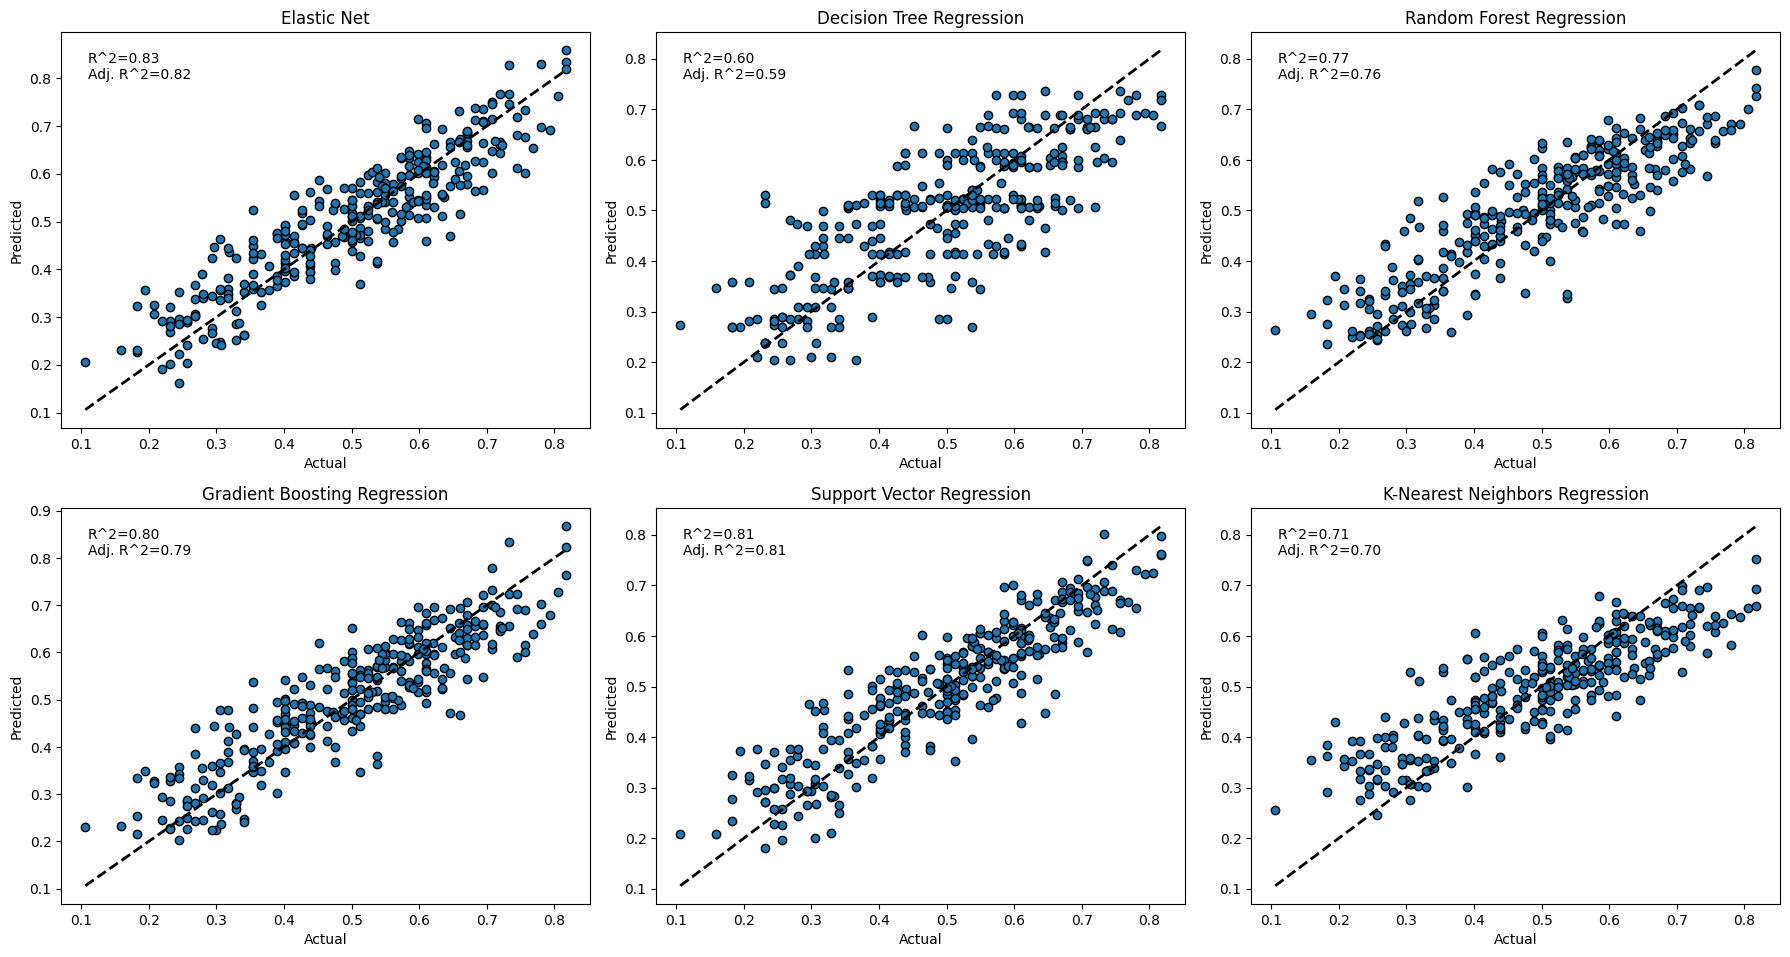

In [81]:
# Models initialization with optimized parameters
models = {
    'Elastic Net': ElasticNet(alpha=0.0008765584072672502, l1_ratio=0.99999, random_state=42),
    'Decision Tree Regression': DecisionTreeRegressor(criterion='squared_error', max_features=5, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01, random_state=42),
    'Random Forest Regression': RandomForestRegressor(criterion='squared_error', max_features=1.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0, random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(criterion='friedman_mse', learning_rate=0.1, loss='squared_error', max_features=1.0, min_samples_leaf=1, min_samples_split=5, min_weight_fraction_leaf=0, subsample=0.6, random_state=42),
    'Support Vector Regression': SVR(C=0.1, degree=3, epsilon=0.01, gamma='scale', kernel='rbf', tol=1e-06),
    'K-Nearest Neighbors Regression': KNeighborsRegressor(algorithm='ball_tree', metric='minkowski', n_neighbors=7, p=3, weights='distance')
}

# Dictionaries to store results
mse_results = {}
r2_results = {}
adj_r2_results = {}

# Training and prediction
n = X_new_tilde_pca.shape[0]
p = X_new_tilde_pca.shape[1]
for name, model in models.items():
    model.fit(X_train_tilde_pca, y_train)
    y_pred = model.predict(X_new_tilde_pca)
    mse_results[name] = mean_squared_error(y_new, y_pred)
    r2_results[name] = r2_score(y_new, y_pred)
    adj_r2_results[name] = 1 - (1 - r2_results[name]) * (n - 1) / (n - p - 1)

# Display results
results = pd.DataFrame({
    'Model': list(mse_results.keys()),
    'MSE': list(mse_results.values()),
    'R-squared': list(r2_results.values()),
    'Adjusted R-squared': list(adj_r2_results.values())
})

print("Model Performance Comparison:")
print(results)

# Plotting actual vs predicted values for each model
plt.figure(figsize=(18, 14))

# Iterate over models for plotting
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(3, 3, i)
    model.fit(X_train_tilde_pca, y_train)
    y_pred = model.predict(X_new_tilde_pca)
    plt.scatter(y_new, y_pred, edgecolors=(0, 0, 0))
    plt.plot([y_new.min(), y_new.max()], [y_new.min(), y_new.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(name)
    plt.text(0.05, 0.95, f'R^2={r2_results[name]:.2f}\nAdj. R^2={adj_r2_results[name]:.2f}',
             transform=plt.gca().transAxes,
             verticalalignment='top')

plt.tight_layout()
plt.show()

Can try to convert into classification problem:

In [82]:
# Load the datasets
all_teams = pd.read_csv('nba2.csv')
playoff_teams = pd.read_csv('nba2_playoffs.csv')

# Create a set of unique team-season combinations that made the playoffs
playoff_set = set(zip(playoff_teams['Team'], playoff_teams['Season']))

# Function to check if a team made the playoffs
def made_playoffs(row):
    return 1 if (row['Team'], row['Season']) in playoff_set else 0

# Apply the function to the large dataset
all_teams['made_playoffs'] = all_teams.apply(made_playoffs, axis=1)

all_teams.head()

,Rk,Season,Team,G,W,L,W/L%,MP,FG,FGA,...,O_ORB,O_DRB,O_TRB,O_AST,O_STL,O_BLK,O_TOV,O_PF,O_PTS,made_playoffs
0,1,2023-24,ATL,82,36,46,0.439,242.1,43.0,92.5,...,10.6,33.6,44.2,28.2,7.8,5.6,14.1,19.4,120.5,0
1,2,2023-24,BOS,82,64,18,0.780,241.8,43.9,90.2,...,11.1,32.3,43.3,24.9,6.2,3.7,12.0,17.3,109.2,1
2,3,2023-24,CHO,82,21,61,0.256,240.6,40.0,87.0,...,10.6,34.8,45.4,28.7,7.1,4.8,13.6,17.5,116.8,0
3,4,2023-24,CHI,82,39,43,0.476,243.7,42.0,89.5,...,10.1,33.3,43.4,27.9,6.8,4.9,14.0,18.8,113.7,0
4,5,2023-24,CLE,82,48,34,0.585,241.5,41.8,87.2,...,10.0,32.6,42.7,25.3,7.7,5.0,13.6,18.7,110.2,1
